In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from visualization_utils import *
import seaborn as sns



In [2]:
numeric_columns = [
    'Year',
    #'Month',
    'Horsepower',
    'CubicCapacity',
    'KmDriven',
    'WLTP_Range_km',
    'Battery_Capacity_kWh'
]

categorical_columns = [
    'Status',
    'City',
    'Area',
    'Brand',
    'Model',
    'EngineType',
    'EuroStandard',
    'TransmissionType',
    'Category',
    'Color',
    'Condition'
]

target_column = 'CarPrice'
all_values = os.listdir('scraping_results/all_values')



In [3]:
# Helpers
def flatten_list(nested_list):
    flat_list = []
    for sublist in nested_list:
        for item in sublist:
            flat_list.append(item)
    return flat_list

def process_list_columns(df, column_name):
    features_df = df[column_name].str.replace("[", '').str.replace("]", '').str.replace("'",'').str.replace(', ',',').str.split(',').fillna('')
    values = list(set(flatten_list(features_df.tolist())))
    df_features = pd.DataFrame({value: features_df.apply(lambda x: value in x).tolist() for value in values})
    return pd.concat([df, df_features], axis=1)

In [4]:
def process_files(files):
    df = pd.concat([
        pd.read_csv('scraping_results/all_values/' + file,index_col=0) for file in files
        ])
    df=df.reset_index()
    # Car Price
    df['CarPrice'] = df['CarPrice'].str.split('<br>').str[1].str.split('лв.').str[0].str.replace(' ', '').astype(float)
    # Car Date
    month_Year_df = pd.DataFrame(df['Дата на производствоTech'].str.split(' ').fillna('').tolist(),columns=['Month','Year'])
    month_Year_df['Month'] = month_Year_df['Month'].map({'януари':'1','февруари':'2','март':'3','април':'4','май':'5','юни':'6',                                                  'юли':'7','август':'8','септември':'9','октомври':'10','ноември':'11','декември':'12'})
    df[['Month', 'Year']] = month_Year_df
    df['Year'] = df['Year'].astype(float)
    # City and Area
    precessed_location = df['Location'].str.replace('гр.','').str.replace('обл. ','').str.replace('с.','').str.replace(' ','').str.split(',')
    df_city = precessed_location.str[0].str.strip()
    df_area = precessed_location.str[1].str.strip()
    df['City'] = df_city # Possible values (Намира се в САЩ)
    df['Area'] = df_area # Possible null values when city is (Намира се в САЩ)
    df['City'].loc[df['Area'].isna()] = "Извън страната"
    # Brand
    df['Brand'] = df['CarModel'].str.split(' ').str[0].str.strip()
    # Model
    df['Model'] = df['CarModel']#.str.split(' ').str[1].str.strip()
    # Horsepower
    df['Horsepower'] = df['МощностInfo'].str.replace(' к.с.','').astype(float)

    # Engine Type
    df['EngineType'] = df['ДвигателTech']

    # Euro Standard
    df['EuroStandard'] = df['ЕвростандартTech']

    # Cubic Capacity
    df['CubicCapacity'] = df['Кубатура [куб.см]'].str.replace(' см<sup>3</sup>','').astype(float)

    # Transmission Type
    df['TransmissionType'] = df['Скоростна кутияTech']

    # Category
    df['Category'] = df['Категория']

    # km driven
    df['KmDriven'] = df['Пробег [км]Tech'].str.replace(' км','').astype(float)

    # Color
    df['Color'] = df['Цвят']
    df['Color'] = df['Color'].str.lower().str.replace('светло', '').str.replace('тъмно', '').str.replace("tъмно",'').str.replace('т.','').str.replace(' ме', '').str.replace('с.','').str.strip()
    
    # Condition
    df['Condition'] = df['Състояние']

    # WLTP Range
    df['WLTP_Range_km'] = df['Пробег с едно зареждане (WLTP) [км]'].str.replace(' км.','').astype(float)

    # Battery Capacity
    df['Battery_Capacity_kWh'] = df['Капацитет на батерията [kWh]'].str.replace(' kWh.','').astype(float)

    # Safety Features
    df = process_list_columns(df, 'Безопасност')
    # Other Features
    df = process_list_columns(df, 'Други')
    # Exterior Features
    df = process_list_columns(df, 'Екстериор')
    # Protection Features
    df = process_list_columns(df, 'Защита')
    # Comfort Features
    df = process_list_columns(df, 'Комфорт')
    # Interior Features
    df = process_list_columns(df, 'Интериор')
    # Specialized Features
    df = process_list_columns(df, 'Специализирани')
    df.drop(columns=['Дата на производствоTech','Дата на производствоInfo','Location','МощностInfo','ДвигателTech','ДвигателInfo','ЕвростандартTech','ЕвростандартInfo',
                 'Кубатура [куб.см]','Скоростна кутияTech','Скоростна кутияInfo','Категория','Пробег [км]Tech','Пробег [км]Info','Цвят','Състояние',
                 'Пробег с едно зареждане (WLTP) [км]','Капацитет на батерията [kWh]','Безопасност','Други','Екстериор','Защита','Комфорт',
                 'Интериор','Специализирани','МощностTech','Params','SmallPictures','BigPictures','VIN номер','CarModel'], inplace=True)
    return df


def remove_outliers_from_numeric_columns(df,columns,drop=False,std_multiplier=3):
    for column in columns:
        if drop:
            df = df.drop(df[df[column] >= df[column].mean() + std_multiplier * df[column].std()].index)
            df = df.drop(df[df[column] <= df[column].mean() - std_multiplier * df[column].std()].index)
        else:
            df[column].loc[df[column] >= df[column].mean() + std_multiplier * df[column].std()] = np.nan
            df[column].loc[df[column] <= df[column].mean() - std_multiplier * df[column].std()] = np.nan
    return df

def sumarize_small_values_in_column(df,column,threshold=0.01):
    value_counts = df[column].value_counts(normalize=True)
    small_values = value_counts[value_counts < threshold].index
    df[column] = df[column].replace(small_values, 'Other')
    return df, small_values

def drop_low_cardinality_columns(df):
    low_cardinality_columns = [column for column in df.columns if len(df[~df[column].isna()]['URL'])<10]
    df = df.drop(low_cardinality_columns,axis = 1)
    return df

In [5]:
df = process_files(all_values)
#df = remove_outliers_from_numeric_columns(df,['Horsepower','CubicCapacity','KmDriven'])
#real_df = pd.read_csv('scraping_results/all_values/' + all_values[0],index_col=0)

C:\Users\sasho\AppData\Local\Temp\ipykernel_20256\3777746785.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['City'].loc[df['Area'].isna()] = "Извън страната"
C:\Users\sasho\AppData\Local\Temp\ipykernel_20256\3777746785.py:19: Settin

In [6]:
print("Initial shape:", df.shape)
df = drop_low_cardinality_columns(df)
print("Shape after dropping low cardinality columns:", df.shape)
df = df.dropna(subset=[target_column])
print("Shape after dropping rows with missing target:", df.shape)
#df = remove_outliers_from_numeric_columns(df,['Horsepower','CubicCapacity','KmDriven'], drop=True, std_multiplier=4)
print("Shape after removing outliers:", df.shape)

Initial shape: (117221, 182)
Shape after dropping low cardinality columns: (117221, 121)
Shape after dropping rows with missing target: (112477, 121)
Shape after removing outliers: (112477, 121)


In [7]:
#df,small_values_brand = sumarize_small_values_in_column(df,'Brand')
df,small_values_city = sumarize_small_values_in_column(df,'City')
df,small_values_area = sumarize_small_values_in_column(df,'Area')
df,small_values_color = sumarize_small_values_in_column(df,'Color')
#df = df.drop('CarDescription',axis=1)
#df,small_values_model = sumarize_small_values_in_column(df,'Model')
#df = df.drop('Status',axis=1)# This column is artificially created by mobile.bg
#df = df.drop('Model',axis=1)# too many unique values
#df = df.drop('Condition',axis=1)# too little values

#categorical_columns.remove('Status')
#categorical_columns.remove('Model')
#categorical_columns.remove('Condition')

In [8]:
for col in numeric_columns:
    print(f"{col}: {df[col].isna().sum()}")

Year: 262
Horsepower: 5977
CubicCapacity: 27207
KmDriven: 448
WLTP_Range_km: 107743
Battery_Capacity_kWh: 107743


In [9]:
for col in categorical_columns:
    missing = df[col].isna().sum()
    print(f"{col}: {missing}")
    if missing > 0:
        df[col] = df[col].fillna('Other')

Status: 0
City: 0
Area: 9594
Brand: 0
Model: 0
EngineType: 57
EuroStandard: 27096
TransmissionType: 57
Category: 57
Color: 10091
Condition: 111554


In [10]:
#for column in categorical_columns:
#    if column == 'Model':
#        continue
#    print(column)
#    display_pie_chart(df[column])

In [11]:
#for column in numeric_columns:
#    print(column)
#    display_points(df[[column,'CarPrice']])

In [12]:
#display_corr_heatmap(df[['CarPrice']+numeric_columns].corr())

In [13]:
#df[categorical_columns] = df[categorical_columns].apply(lambda x: x.cat.codes) # Label encoding
#display_corr_heatmap(df[['CarPrice']+categorical_columns].corr())

Car price hist


<Axes: xlabel='CarPrice', ylabel='Count'>

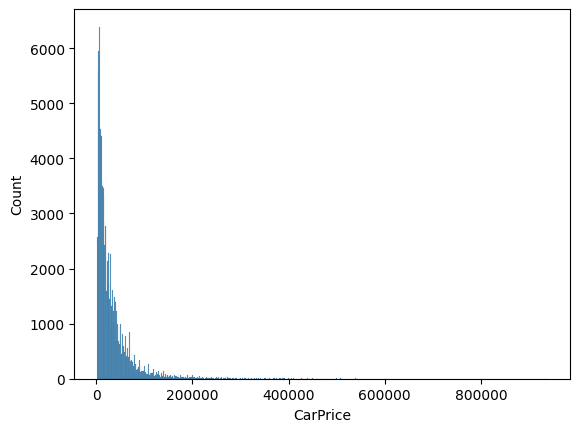

In [12]:
print("Car price hist")
sns.histplot(df['CarPrice'])

Log Car price hist


<Axes: xlabel='CarPrice', ylabel='Count'>

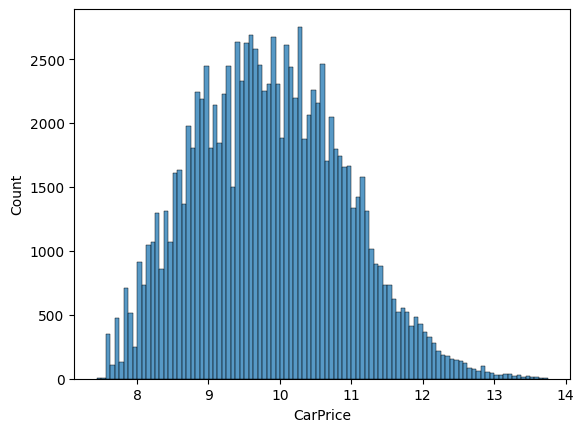

In [16]:
print("Log Car price hist")
sns.histplot(np.log(df['CarPrice']))
#

In [16]:
df = df.drop(columns=['index'])

In [17]:
df.to_csv('processed_data/preprocessed_car_data_full_brand_with_outliers_description.csv',index=False)